In [1]:
import json
import sys
from pathlib import Path

import polars as pl
import pyarrow.dataset as ds

print(sys.executable)

d:\SudhakarF\DocumentsF\SanDiego\Course_10_MLOps\FinalProject\ueba_eda\.venv\Scripts\python.exe


In [2]:
ROOT_DIR = Path.cwd().parent

BASE_DIR = ROOT_DIR /"data" / "r6.2"
RAW_DATASET_DIR = BASE_DIR / "raw"
BRONZE_DATASET_DIR = BASE_DIR / "bronze"
SILVER_DATASET_DIR = BASE_DIR / "silver"
GOLD_DATASET_DIR = BASE_DIR / "gold"

DATASET_FILE_NAMES = ["logon", "device", "email", "file", "http", "decoy_file"]

force_recompute = True
verbose = True

In [3]:
for filename in DATASET_FILE_NAMES:
    print(f"Scanning parquet file: {filename}")
    lz = pl.scan_csv(str(RAW_DATASET_DIR / f"{filename}.csv"))
    print(lz.limit(5).collect())

Scanning parquet file: logon
shape: (5, 5)
┌──────────────────────────┬─────────────────────┬─────────┬─────────┬──────────┐
│ id                       ┆ date                ┆ user    ┆ pc      ┆ activity │
│ ---                      ┆ ---                 ┆ ---     ┆ ---     ┆ ---      │
│ str                      ┆ str                 ┆ str     ┆ str     ┆ str      │
╞══════════════════════════╪═════════════════════╪═════════╪═════════╪══════════╡
│ {F3X8-Y2GT43DR-4906OHBL} ┆ 01/02/2010 02:19:18 ┆ DNS1758 ┆ PC-0414 ┆ Logon    │
│ {B4Q0-D0GM24KN-3704MAII} ┆ 01/02/2010 02:31:12 ┆ DNS1758 ┆ PC-0414 ┆ Logoff   │
│ {T7J1-D4HK34KV-5476TCIJ} ┆ 01/02/2010 02:34:02 ┆ DNS1758 ┆ PC-5313 ┆ Logon    │
│ {S4Y6-D8MQ05SA-0759HLIS} ┆ 01/02/2010 02:53:30 ┆ DNS1758 ┆ PC-5313 ┆ Logoff   │
│ {F3P0-E7FH78CV-4874FRGZ} ┆ 01/02/2010 04:07:31 ┆ DNS1758 ┆ PC-0012 ┆ Logon    │
└──────────────────────────┴─────────────────────┴─────────┴─────────┴──────────┘
Scanning parquet file: device
shape: (5, 6)
┌──────────

In [4]:
def format_size(bytes_size: int) -> str:
    """
    Converts a size in bytes to a human-readable format (e.g, KB, MB, GB)
    """
    for unit in ["B", "KB", "MB", "GB", "TB"]:
        if bytes_size < 1024:
            return f"{bytes_size:.2f} {unit}"
        bytes_size /= 1024
    return f"{bytes_size:.2f} PB"


def get_storage_size(path: str | Path):
    """
    Calculates the total physical disk footprint of the dataset in bytes.
    """
    path = Path(path)
    if path.is_file():
        return path.stat().st_size
    else:
        return sum(f.stat().st_size for f in path.rglob("*") if f.is_file())

In [5]:
def compare_dataset_sizes(
    raw_dataset_path: str | Path,
    processed_dataset_path: str | Path,
    verbose: bool = False,
) -> None:
    """
    Inspects parquet file or partitioned parquet directory safely.

    - Prints total size on disk
    - Prints schema (lazy)
    - Prints first 5 rows (lazy)
    """

    # --------------------------------------------------
    # Comparison of raw vs processed dataset sizes
    # --------------------------------------------------

    if not raw_dataset_path.exists():
        print(f"[ERROR] Raw dataset path does not exist: {raw_dataset_path}")
        return
    if not processed_dataset_path.exists():
        print(
            f"[ERROR] Processed dataset path does not exist: {processed_dataset_path}"
        )
        return

    total_size_raw = get_storage_size(raw_dataset_path)
    total_size_processed = get_storage_size(processed_dataset_path)

    total_size_raw_formatted = format_size(total_size_raw)
    total_size_processed_formatted = format_size(total_size_processed)

    if verbose:
        print("\n==============================")
        print("Dataset Size Comparison:")
        print(f"Raw Dataset Path      : {Path(*raw_dataset_path.parts[6:])}")
        print(f"Processed Dataset Path: {Path(*processed_dataset_path.parts[6:])}")
        print(f"Raw Dataset Size      : {total_size_raw_formatted}")
        print(f"Processed Dataset Size: {total_size_processed_formatted}")
        if total_size_raw > 0:
            reduction_pct = (1 - (total_size_processed / total_size_raw)) * 100

            print(
                f"Size Reduction        : "
                f"{total_size_raw_formatted} -> {total_size_processed_formatted} "
                f"({reduction_pct:.2f}% reduction)"
            )

        else:
            print(
                f"Size Reduction        : {total_size_raw_formatted} -> {total_size_processed_formatted} (N/A - raw size is zero)"
            )
        print("==============================\n")

    return {
        "raw_size": total_size_raw,
        "processed_size": total_size_processed,
        "reduction_pct": reduction_pct if total_size_raw > 0 else 0,
    }

#### Compare Dataset sizes for BRONZE datasets (RAW CSV -> RAW PARQUET file(s)/folder(s))

In [ ]:
for filename in DATASET_FILE_NAMES:
    raw_dataset_path = RAW_DATASET_DIR / f"{filename}.csv"
    processed_dataset_path = BRONZE_DATASET_DIR / f"{filename}.parquet"
    dataset_sizes = compare_dataset_sizes(
        raw_dataset_path, processed_dataset_path, verbose=verbose
    )


Dataset Size Comparison:
Raw Dataset Path      : ueba_eda\data\r6.2\raw\logon.csv
Processed Dataset Path: ueba_eda\data\r6.2\bronze\logon.parquet
Raw Dataset Size      : 230.45 MB
Processed Dataset Size: 90.87 MB
Size Reduction        : 230.45 MB -> 90.87 MB (60.57% reduction)


Dataset Size Comparison:
Raw Dataset Path      : ueba_eda\data\r6.2\raw\device.csv
Processed Dataset Path: ueba_eda\data\r6.2\bronze\device.parquet
Raw Dataset Size      : 133.08 MB
Processed Dataset Size: 43.47 MB
Size Reduction        : 133.08 MB -> 43.47 MB (67.33% reduction)


Dataset Size Comparison:
Raw Dataset Path      : ueba_eda\data\r6.2\raw\email.csv
Processed Dataset Path: ueba_eda\data\r6.2\bronze\email.parquet
Raw Dataset Size      : 7.53 GB
Processed Dataset Size: 3.04 GB
Size Reduction        : 7.53 GB -> 3.04 GB (59.59% reduction)


Dataset Size Comparison:
Raw Dataset Path      : ueba_eda\data\r6.2\raw\file.csv
Processed Dataset Path: ueba_eda\data\r6.2\bronze\file.parquet
Raw Dataset Size   

#### Dataset summary for RAW PARQUET FILES

In [29]:
def dataset_summary(
    path: str | Path, force_recompute: bool = False, verbose: bool = False
) -> dict:
    """ """
    path = Path(path)
    dataset = ds.dataset(str(path), format="parquet")
    summary_path = BASE_DIR / "profiling" / f"{path.stem}_summary.json"

    if summary_path.exists() and not force_recompute:
        print(f"Loading cached summary for {path.name}...\n")
        with open(summary_path, "r") as f:
            summary = json.load(f)
    else:
        # crete summary path if it doesn't exist
        summary_path.parent.mkdir(parents=True, exist_ok=True)

        total_files = 0
        total_rows = 0
        col_metadata = {}
        for fragment in dataset.get_fragments():
            total_files += 1
            fragment_meta = fragment.metadata
            total_rows += fragment_meta.num_rows

            for row_group_idx in range(fragment_meta.num_row_groups):
                row_group_meta = fragment_meta.row_group(row_group_idx)

                for col_idx in range(row_group_meta.num_columns):
                    col_chunk = row_group_meta.column(col_idx)
                    col_name = col_chunk.path_in_schema
                    col_stats = col_chunk.statistics

                    if col_stats is None:
                        continue

                    if col_name not in col_metadata:
                        col_metadata[col_name] = {
                            "not_null_count": 0,
                            "null_count": 0,
                            "min": None,
                            "max": None,
                        }

                    # Aggregate counts
                    col_metadata[col_name]["not_null_count"] += (
                        col_stats.num_values or 0
                    )
                    col_metadata[col_name]["null_count"] += col_stats.null_count or 0

                    # Min
                    if col_stats.has_min_max and col_stats.min is not None:
                        current_min = col_metadata[col_name]["min"]
                        col_metadata[col_name]["min"] = (
                            col_stats.min
                            if current_min is None
                            else min(current_min, col_stats.min)
                        )

                    # Max
                    if col_stats.has_min_max and col_stats.max is not None:
                        current_max = col_metadata[col_name]["max"]
                        col_metadata[col_name]["max"] = (
                            col_stats.max
                            if current_max is None
                            else max(current_max, col_stats.max)
                        )

        lf = pl.scan_parquet(str(path))
        sample = (
                lf
                .limit(5)
                .collect()
                .glimpse(return_type="string")
            )


        summary = {
            "dataset_name": path.name,
            "dataset_path": str(Path(*path.parts[6:])),
            "dataset_memory_size": format_size(get_storage_size(path)),
            "schema": [(field.name, str(field.type)) for field in dataset.schema],
            "total_files": total_files,
            "total_rows": total_rows,
            "columns": col_metadata,
            "sample": sample,
        }

        with open(summary_path, "w") as f:
            json.dump(summary, f, indent=2, default=str)

    if verbose:
        print("\n" + "=" * 60)
        print("DATASET METADATA SUMMARY")
        print("=" * 60)

        print(f"Dataset Name : {summary['dataset_name']}")
        print(f"Dataset Path : {summary['dataset_path']}")
        print(f"Memory Size : {summary['dataset_memory_size']}")

        print("\nSCHEMA")
        print("-" * 60)
        for name, dtype in summary["schema"]:
            print(f"{name:<25} {dtype}")

        print("\nDATASET OVERVIEW")
        print("-" * 60)
        print(f"Total Files : {summary['total_files']}")
        print(f"Total Rows  : {summary['total_rows']:,}")

        print("\nCOLUMN STATISTICS")
        print("-" * 60)
        for col, stats in summary["columns"].items():
            print(f"\n{col}")
            print(f"  Non-Null Count : {stats['not_null_count']:,}")
            print(f"  Null Count     : {stats['null_count']:,}")
            print(f"  Min            : {stats['min']}")
            print(f"  Max            : {stats['max']}")

        print("\nSAMPLE (First 5 Rows)")
        print("-" * 60)
        print(summary["sample"])

        print("\n" + "=" * 60 + "\n")

    return summary

In [ ]:
## logon dataset summary
logon_summary = dataset_summary(
    BRONZE_DATASET_DIR / "logon.parquet",
    force_recompute=force_recompute,
    verbose=verbose,
)


DATASET METADATA SUMMARY
Dataset Name : logon.parquet
Dataset Path : ueba_eda\data\r6.2\bronze\logon.parquet
Memory Size : 90.87 MB

SCHEMA
------------------------------------------------------------
id                        large_string
user                      large_string
pc                        large_string
activity                  large_string
timestamp                 timestamp[us]

DATASET OVERVIEW
------------------------------------------------------------
Total Files : 523
Total Rows  : 3,530,285

COLUMN STATISTICS
------------------------------------------------------------

id
  Non-Null Count : 3,530,285
  Null Count     : 0
  Min            : {A0A0-A2DT76JF-3051XWBA}
  Max            : {Z9Z9-Z3EM53KV-0163FIEO}

user
  Non-Null Count : 3,530,285
  Null Count     : 0
  Min            : AAB0162
  Max            : ZZO2997

pc
  Non-Null Count : 3,530,285
  Null Count     : 0
  Min            : PC-0001
  Max            : PC-9996

activity
  Non-Null Count : 3,530,285
  

In [ ]:
## device dataset summary
device_summary = dataset_summary(
    BRONZE_DATASET_DIR / "device.parquet",
    force_recompute=force_recompute,
    verbose=verbose,
)


DATASET METADATA SUMMARY
Dataset Name : device.parquet
Dataset Path : ueba_eda\data\r6.2\bronze\device.parquet
Memory Size : 43.47 MB

SCHEMA
------------------------------------------------------------
id                        large_string
user                      large_string
pc                        large_string
file_tree                 large_string
activity                  large_string
timestamp                 timestamp[us]

DATASET OVERVIEW
------------------------------------------------------------
Total Files : 518
Total Rows  : 1,551,828

COLUMN STATISTICS
------------------------------------------------------------

id
  Non-Null Count : 1,551,828
  Null Count     : 0
  Min            : {A0A0-A2LF00HC-9260HFAU}
  Max            : {Z9Z9-Z2FL65FI-5646FSCT}

user
  Non-Null Count : 1,551,828
  Null Count     : 0
  Min            : AAC0610
  Max            : ZRM0694

pc
  Non-Null Count : 1,551,828
  Null Count     : 0
  Min            : PC-0001
  Max            : PC-9996


In [ ]:
## email dataset summary
email_summary = dataset_summary(
    BRONZE_DATASET_DIR / "email.parquet",
    force_recompute=force_recompute,
    verbose=verbose,
)


DATASET METADATA SUMMARY
Dataset Name : email.parquet
Dataset Path : ueba_eda\data\r6.2\bronze\email.parquet
Memory Size : 3.04 GB

SCHEMA
------------------------------------------------------------
id                        large_string
user                      large_string
pc                        large_string
to                        large_string
cc                        large_string
bcc                       large_string
from                      large_string
activity                  large_string
size                      int64
attachments               large_string
content                   large_string
timestamp                 timestamp[us]

DATASET OVERVIEW
------------------------------------------------------------
Total Files : 536
Total Rows  : 10,994,957

COLUMN STATISTICS
------------------------------------------------------------

id
  Non-Null Count : 10,994,957
  Null Count     : 0
  Min            : {A0A0-A1OS05HH-5522FYZC}
  Max            : {Z9Z9-Z9HS16AF-72

In [20]:
## file dataset summary
file_summary = dataset_summary(
    BRONZE_DATASET_DIR / "file.parquet",
    force_recompute=force_recompute,
    verbose=verbose,
)


DATASET METADATA SUMMARY
Dataset Name : file.parquet
Dataset Path : ueba_eda\data\r6.2\bronze\file.parquet
Memory Size : 358.55 MB

SCHEMA
------------------------------------------------------------
id                        large_string
user                      large_string
pc                        large_string
filename                  large_string
activity                  large_string
to_removable_media        bool
from_removable_media      bool
content                   large_string
timestamp                 timestamp[us]

DATASET OVERVIEW
------------------------------------------------------------
Total Files : 519
Total Rows  : 2,014,883

COLUMN STATISTICS
------------------------------------------------------------

id
  Non-Null Count : 2,014,883
  Null Count     : 0
  Min            : {A0A0-A0EU53QX-9893ZLWH}
  Max            : {Z9Z9-Y9MF65DD-0026DQPL}

user
  Non-Null Count : 2,014,883
  Null Count     : 0
  Min            : AAB0162
  Max            : ZZO2997

pc
  Non-

In [ ]:
## http dataset summary
http_summary = dataset_summary(
    BRONZE_DATASET_DIR / "http.parquet",
    force_recompute=force_recompute,
    verbose=verbose,
)


DATASET METADATA SUMMARY
Dataset Name : http.parquet
Dataset Path : ueba\data\processed\r6.2\parquet\http.parquet
Memory Size : 23.59 GB

SCHEMA
------------------------------------------------------------
id                        large_string
user                      large_string
pc                        large_string
url                       large_string
activity                  large_string
content                   large_string
timestamp                 timestamp[us]

DATASET OVERVIEW
------------------------------------------------------------
Total Files : 661
Total Rows  : 117,025,216

COLUMN STATISTICS
------------------------------------------------------------

id
  Non-Null Count : 117,025,216
  Null Count     : 0
  Min            : {A0A0-A0BE95BB-9636BWMU}
  Max            : {Z9Z9-Z9KR22UZ-1017APZF}

user
  Non-Null Count : 117,025,216
  Null Count     : 0
  Min            : AAB0162
  Max            : ZZO2997

pc
  Non-Null Count : 117,025,216
  Null Count     : 0
  Mi

In [ ]:
## decoy_file dataset summary
decoy_file_summary = dataset_summary(
    BRONZE_DATASET_DIR / "decoy_file.parquet",
    force_recompute=force_recompute,
    verbose=verbose,
)


DATASET METADATA SUMMARY
Dataset Name : decoy_file.parquet
Dataset Path : ueba\data\processed\r6.2\parquet\decoy_file.parquet
Memory Size : 413.15 KB

SCHEMA
------------------------------------------------------------
decoy_filename            large_string
pc                        large_string

DATASET OVERVIEW
------------------------------------------------------------
Total Files : 1
Total Rows  : 31,095

COLUMN STATISTICS
------------------------------------------------------------

decoy_filename
  Non-Null Count : 31,095
  Null Count     : 0
  Min            : C:\002O8QH7.doc
  Max            : C:\ZZSAETN6.doc

pc
  Non-Null Count : 31,095
  Null Count     : 0
  Min            : PC-0001
  Max            : PC-9996

SAMPLE (First 5 Rows)
------------------------------------------------------------
shape: (5, 2)
┌─────────────────────────┬─────────┐
│ decoy_filename          ┆ pc      │
│ ---                     ┆ ---     │
│ str                     ┆ str     │
╞═════════════════

#### Compare Dataset sizes for SILVER datasets (ROW- LEVEL PROCESSED PARQUETS)

In [7]:
for filename in DATASET_FILE_NAMES:
    raw_dataset_path =  BRONZE_DATASET_DIR / f"{filename}.parquet"
    processed_dataset_path = SILVER_DATASET_DIR / f"{filename}_preprocessed.parquet"
    dataset_sizes = compare_dataset_sizes(
        raw_dataset_path, processed_dataset_path, verbose=verbose
    )


Dataset Size Comparison:
Raw Dataset Path      : ueba_eda\data\r6.2\bronze\logon.parquet
Processed Dataset Path: ueba_eda\data\r6.2\silver\logon_preprocessed.parquet
Raw Dataset Size      : 90.87 MB
Processed Dataset Size: 92.04 MB
Size Reduction        : 90.87 MB -> 92.04 MB (-1.29% reduction)


Dataset Size Comparison:
Raw Dataset Path      : ueba_eda\data\r6.2\bronze\device.parquet
Processed Dataset Path: ueba_eda\data\r6.2\silver\device_preprocessed.parquet
Raw Dataset Size      : 43.47 MB
Processed Dataset Size: 40.79 MB
Size Reduction        : 43.47 MB -> 40.79 MB (6.17% reduction)


Dataset Size Comparison:
Raw Dataset Path      : ueba_eda\data\r6.2\bronze\email.parquet
Processed Dataset Path: ueba_eda\data\r6.2\silver\email_preprocessed.parquet
Raw Dataset Size      : 3.04 GB
Processed Dataset Size: 3.35 GB
Size Reduction        : 3.04 GB -> 3.35 GB (-10.08% reduction)


Dataset Size Comparison:
Raw Dataset Path      : ueba_eda\data\r6.2\bronze\file.parquet
Processed Dataset P

In [25]:
for filename in DATASET_FILE_NAMES:
    if filename == "decoy_file":
        continue
    raw_dataset_path =  SILVER_DATASET_DIR / f"{filename}_preprocessed.parquet"
    processed_dataset_path = GOLD_DATASET_DIR / "features" / f"{filename}_features.parquet"
    dataset_sizes = compare_dataset_sizes(
        raw_dataset_path, processed_dataset_path, verbose=verbose
    )


Dataset Size Comparison:
Raw Dataset Path      : ueba_eda\data\r6.2\silver\logon_preprocessed.parquet
Processed Dataset Path: ueba_eda\data\r6.2\gold\features\logon_features.parquet
Raw Dataset Size      : 92.04 MB
Processed Dataset Size: 8.67 MB
Size Reduction        : 92.04 MB -> 8.67 MB (90.58% reduction)


Dataset Size Comparison:
Raw Dataset Path      : ueba_eda\data\r6.2\silver\device_preprocessed.parquet
Processed Dataset Path: ueba_eda\data\r6.2\gold\features\device_features.parquet
Raw Dataset Size      : 40.79 MB
Processed Dataset Size: 387.68 KB
Size Reduction        : 40.79 MB -> 387.68 KB (99.07% reduction)


Dataset Size Comparison:
Raw Dataset Path      : ueba_eda\data\r6.2\silver\email_preprocessed.parquet
Processed Dataset Path: ueba_eda\data\r6.2\gold\features\email_features.parquet
Raw Dataset Size      : 3.35 GB
Processed Dataset Size: 15.14 MB
Size Reduction        : 3.35 GB -> 15.14 MB (99.56% reduction)


Dataset Size Comparison:
Raw Dataset Path      : ueba_eda

#### Dataset Summary of processed GOLD features

In [28]:
gold_features_summary = []
for filename in DATASET_FILE_NAMES:
    if filename == "decoy_file":
        continue
    processed_dataset_path = GOLD_DATASET_DIR / "features" / f"{filename}_features.parquet"
    gold_features_summary.append(dataset_summary(processed_dataset_path, force_recompute=False, verbose=True))

Loading cached summary for logon_features.parquet...


DATASET METADATA SUMMARY
Dataset Name : logon_features.parquet
Dataset Path : ueba_eda\data\r6.2\gold\features\logon_features.parquet
Memory Size : 8.67 MB

SCHEMA
------------------------------------------------------------
user                      large_string
date                      date32[day]
logon_count               uint32
unique_pc_count           uint32
first_logon_hour          int8
last_activity_hour        int8
after_hours_logon_count   int64
weekend_flag              int8
logon_count_zscore        double
work_duration_hours       int8

DATASET OVERVIEW
------------------------------------------------------------
Total Files : 1
Total Rows  : 1,394,010

COLUMN STATISTICS
------------------------------------------------------------

user
  Non-Null Count : 1,394,010
  Null Count     : 0
  Min            : aab0162
  Max            : zzo2997

date
  Non-Null Count : 1,394,010
  Null Count     : 0
  Min            : 2010

In [3]:
import pandas as pd

GOLDEN_FEATURES_PATH = GOLD_DATASET_DIR / "features"

# Load parquet files
logon  = pd.read_parquet(GOLDEN_FEATURES_PATH / "logon_features.parquet", dtype_backend="numpy_nullable")
device = pd.read_parquet(GOLDEN_FEATURES_PATH / "device_features.parquet", dtype_backend="numpy_nullable")
email  = pd.read_parquet(GOLDEN_FEATURES_PATH / "email_features.parquet", dtype_backend="numpy_nullable")
file   = pd.read_parquet(GOLDEN_FEATURES_PATH / "file_features.parquet", dtype_backend="numpy_nullable")
http   = pd.read_parquet(GOLDEN_FEATURES_PATH / "http_features.parquet", dtype_backend="numpy_nullable")

# Normalize user casing
for df in [logon, device, email, file, http]:
    df["user"] = df["user"].str.lower()

# Merge step-by-step (left joins)
user_day_behavioural_features = (
    logon
    .merge(device, on=["user", "date"], how="left")
    .merge(email,  on=["user", "date"], how="left")
    .merge(file,   on=["user", "date"], how="left")
    .merge(http,   on=["user", "date"], how="left")
)

# Fill numeric nulls with 0
numeric_cols = user_day_behavioural_features.select_dtypes(include=["number"]).columns
user_day_behavioural_features[numeric_cols] = user_day_behavioural_features[numeric_cols].fillna(0)

print(user_day_behavioural_features.shape)

(1394010, 40)


In [4]:
user_day_behavioural_features["date"] = pd.to_datetime(user_day_behavioural_features["date"])

In [5]:
user_day_behavioural_features.info()

<class 'pandas.DataFrame'>
RangeIndex: 1394010 entries, 0 to 1394009
Data columns (total 40 columns):
 #   Column                    Non-Null Count    Dtype        
---  ------                    --------------    -----        
 0   user                      1394010 non-null  string       
 1   date                      1394010 non-null  datetime64[s]
 2   logon_count               1394010 non-null  UInt32       
 3   unique_pc_count           1394010 non-null  UInt32       
 4   first_logon_hour          1394010 non-null  Int8         
 5   last_activity_hour        1394010 non-null  Int8         
 6   after_hours_logon_count   1394010 non-null  Int64        
 7   weekend_flag              1394010 non-null  Int8         
 8   logon_count_zscore        1394010 non-null  Float64      
 9   work_duration_hours       1394010 non-null  Int8         
 10  usb_connect_count         1394010 non-null  Int64        
 11  usb_disconnect_count      1394010 non-null  Int64        
 12  incomplete_

In [6]:
user_day_behavioural_features.describe().T

,count,mean,min,25%,50%,75%,max,std
date,1394010,2010-09-10 12:16:37,2010-01-02 00:00:00,2010-05-04 00:00:00,2010-09-08 00:00:00,2011-01-19 00:00:00,2011-06-01 00:00:00,NaN
logon_count,1394010.0,2.532467,1.0,2.0,2.0,3.0,18.0,1.231706
unique_pc_count,1394010.0,1.122495,1.0,1.0,1.0,1.0,7.0,0.556829
first_logon_hour,1394010.0,7.37624,0.0,7.0,7.0,8.0,20.0,1.087493
last_activity_hour,1394010.0,16.971906,0.0,16.0,17.0,18.0,23.0,1.477799
after_hours_logon_count,1394010.0,0.728274,0.0,0.0,1.0,1.0,15.0,1.004542
weekend_flag,1394010.0,0.208295,0.0,0.0,0.0,0.0,1.0,0.406089
logon_count_zscore,1394010.0,0.0,-21.679532,0.0,0.0,0.0,18.814962,0.683662
work_duration_hours,1394010.0,9.595666,0.0,9.0,9.0,10.0,23.0,1.791349
usb_connect_count,1394010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
missing_report = (
    user_day_behavioural_features.isna()
         .mean()
         .sort_values(ascending=False)
         .to_frame("missing_ratio")
)
missing_report

,missing_ratio
user,0.0
date,0.0
logon_count,0.0
unique_pc_count,0.0
first_logon_hour,0.0
last_activity_hour,0.0
after_hours_logon_count,0.0
weekend_flag,0.0
logon_count_zscore,0.0
work_duration_hours,0.0


In [8]:
user_day_behavioural_features.duplicated().sum() # No duplicates

np.int64(0)

In [9]:
user_day_behavioural_features["user"].nunique()

4000

In [10]:
user_day_behavioural_features.groupby("user").size().describe()

count    4000.000000
mean      348.502500
std        62.842571
min        21.000000
25%       356.000000
50%       356.000000
75%       356.000000
max       515.000000
dtype: float64

In [15]:
user_day_behavioural_features["date"].nunique()

516

In [16]:
user_day_behavioural_features.head()

,user,date,logon_count,unique_pc_count,first_logon_hour,last_activity_hour,after_hours_logon_count,weekend_flag,logon_count_zscore,work_duration_hours,...,file_copy_zscore,http_request_count,unique_url_count,unique_domain_count,suspicious_url_count,after_hours_http_count,weekend_http_flag,mean_url_length,http_count_zscore,domain_count_zscore
0,bov1609,2010-08-14,2,1,7,15,1,1,0.0,8,...,0.0,162,40,39,0,10,1,90.58642,0.0,0.395101
1,veb3671,2010-08-14,2,1,7,19,2,1,-0.321401,12,...,0.0,10,4,4,0,0,1,77.9,0.0,-2.936455
2,lqw1314,2010-08-14,2,1,7,17,1,1,-1.555572,10,...,0.0,95,21,19,0,0,1,103.957895,0.0,-1.304905
3,bys3626,2010-08-14,3,1,7,15,1,1,0.54217,8,...,0.0,10,8,8,0,1,1,85.5,0.0,-0.14721
4,abk3081,2010-08-14,3,1,8,18,0,1,-0.36793,10,...,0.0,95,24,27,0,0,1,87.042105,0.0,-0.399305


In [17]:
insiders = pd.read_csv(GOLDEN_FEATURES_PATH / "insiders.csv")

In [18]:
insiders.head()

,dataset,scenario,details,user,start,end
0,2.0,1,r2.csv,ONS0995,3/6/2010 1:41:56,3/20/2010 8:10:12
1,3.1,1,r3.1-1.csv,CSF0929,07/01/2010 01:24:58,07/16/2010 06:52:00
2,3.1,2,r3.1-2.csv,CCH0959,08/02/2010 10:34:31,09/30/2010 15:04:03
3,3.2,1,r3.2-1.csv,RCW0822,09/29/2010 21:10:27,10/15/2010 06:34:52
4,3.2,2,r3.2-2.csv,JCE0258,07/12/2010 08:16:02,09/03/2010 16:16:29


In [19]:
insiders = insiders[insiders['dataset'] == 6.2].copy()
insiders.head()

,dataset,scenario,details,user,start,end
186,6.2,1,r6.2-1.csv,ACM2278,8/18/2010 21:47:42,08/24/2010 03:48:51
187,6.2,2,r6.2-2.csv,CMP2946,02/07/2011 12:28:06,03/04/2011 12:30:25
188,6.2,3,r6.2-3.csv,PLJ1771,8/12/2010 08:09:00,08/12/2010 16:11:39
189,6.2,4,r6.2-4.csv,CDE1846,/21/2011 11:43:39,04/25/2011 17:55:00
190,6.2,5,r6.2-5.csv,MBG3183,10/12/2010 13:21:59,10/12/2010 13:22:56


In [20]:
insiders.loc[
    insiders["user"] == "CDE1846",
    "start"
] = "04/21/2011 11:43:39"
insiders.head()

,dataset,scenario,details,user,start,end
186,6.2,1,r6.2-1.csv,ACM2278,8/18/2010 21:47:42,08/24/2010 03:48:51
187,6.2,2,r6.2-2.csv,CMP2946,02/07/2011 12:28:06,03/04/2011 12:30:25
188,6.2,3,r6.2-3.csv,PLJ1771,8/12/2010 08:09:00,08/12/2010 16:11:39
189,6.2,4,r6.2-4.csv,CDE1846,04/21/2011 11:43:39,04/25/2011 17:55:00
190,6.2,5,r6.2-5.csv,MBG3183,10/12/2010 13:21:59,10/12/2010 13:22:56


In [21]:
# Convert start column
insiders["start"] = pd.to_datetime(
    insiders["start"],
    errors="coerce"
)

# Convert end column
insiders["end"] = pd.to_datetime(
    insiders["end"],
    errors="coerce"
)
insiders.head()

,dataset,scenario,details,user,start,end
186,6.2,1,r6.2-1.csv,ACM2278,2010-08-18 21:47:42,2010-08-24 03:48:51
187,6.2,2,r6.2-2.csv,CMP2946,2011-02-07 12:28:06,2011-03-04 12:30:25
188,6.2,3,r6.2-3.csv,PLJ1771,2010-08-12 08:09:00,2010-08-12 16:11:39
189,6.2,4,r6.2-4.csv,CDE1846,2011-04-21 11:43:39,2011-04-25 17:55:00
190,6.2,5,r6.2-5.csv,MBG3183,2010-10-12 13:21:59,2010-10-12 13:22:56


In [22]:
insiders["start_date"] = insiders["start"].dt.date
insiders["end_date"] = insiders["end"].dt.date
insiders["user"] = insiders["user"].str.lower()
insiders.head()

,dataset,scenario,details,user,start,end,start_date,end_date
186,6.2,1,r6.2-1.csv,acm2278,2010-08-18 21:47:42,2010-08-24 03:48:51,2010-08-18,2010-08-24
187,6.2,2,r6.2-2.csv,cmp2946,2011-02-07 12:28:06,2011-03-04 12:30:25,2011-02-07,2011-03-04
188,6.2,3,r6.2-3.csv,plj1771,2010-08-12 08:09:00,2010-08-12 16:11:39,2010-08-12,2010-08-12
189,6.2,4,r6.2-4.csv,cde1846,2011-04-21 11:43:39,2011-04-25 17:55:00,2011-04-21,2011-04-25
190,6.2,5,r6.2-5.csv,mbg3183,2010-10-12 13:21:59,2010-10-12 13:22:56,2010-10-12,2010-10-12


In [23]:
columns = ["user", "start_date", "end_date"]
insiders = insiders[columns]

In [24]:
insiders.head()

,user,start_date,end_date
186,acm2278,2010-08-18,2010-08-24
187,cmp2946,2011-02-07,2011-03-04
188,plj1771,2010-08-12,2010-08-12
189,cde1846,2011-04-21,2011-04-25
190,mbg3183,2010-10-12,2010-10-12


In [25]:
ueba = user_day_behavioural_features.merge(
    insiders,
    on="user",
    how="left")

ueba.head()

,user,date,logon_count,unique_pc_count,first_logon_hour,last_activity_hour,after_hours_logon_count,weekend_flag,logon_count_zscore,work_duration_hours,...,unique_url_count,unique_domain_count,suspicious_url_count,after_hours_http_count,weekend_http_flag,mean_url_length,http_count_zscore,domain_count_zscore,start_date,end_date
0,bov1609,2010-08-14,2,1,7,15,1,1,0.0,8,...,40,39,0,10,1,90.58642,0.0,0.395101,NaN,NaN
1,veb3671,2010-08-14,2,1,7,19,2,1,-0.321401,12,...,4,4,0,0,1,77.9,0.0,-2.936455,NaN,NaN
2,lqw1314,2010-08-14,2,1,7,17,1,1,-1.555572,10,...,21,19,0,0,1,103.957895,0.0,-1.304905,NaN,NaN
3,bys3626,2010-08-14,3,1,7,15,1,1,0.54217,8,...,8,8,0,1,1,85.5,0.0,-0.14721,NaN,NaN
4,abk3081,2010-08-14,3,1,8,18,0,1,-0.36793,10,...,24,27,0,0,1,87.042105,0.0,-0.399305,NaN,NaN


In [26]:
ueba["target"] = (
    (ueba["user"].isin(insiders["user"])) &
    (ueba["date"] >= ueba["start_date"]) &
    (ueba["date"] <= ueba["end_date"])
).astype(int)
ueba.drop(columns=["start_date", "end_date"], inplace=True)


In [27]:
ueba["target"].value_counts(normalize=True)

target
0    0.999978
1    0.000022
Name: proportion, dtype: float64

In [28]:
ueba = (
    ueba.drop(columns=ueba.nunique()[ueba.nunique() == 1].index)
)

In [29]:
ueba.columns

Index(['user', 'date', 'logon_count', 'unique_pc_count', 'first_logon_hour',
       'last_activity_hour', 'after_hours_logon_count', 'weekend_flag',
       'logon_count_zscore', 'work_duration_hours', 'email_count',
       'send_count', 'after_hours_email_count', 'external_email_ratio',
       'attachment_per_email', 'email_volume_deviation',
       'external_ratio_deviation', 'usb_copy_count', 'usb_read_count',
       'after_hours_file_count', 'unique_file_count', 'avg_keyword_count',
       'http_request_count', 'unique_url_count', 'unique_domain_count',
       'suspicious_url_count', 'after_hours_http_count', 'weekend_http_flag',
       'mean_url_length', 'http_count_zscore', 'domain_count_zscore',
       'target'],
      dtype='str')

## EDA

### Log-Scale Target Distribution Plot

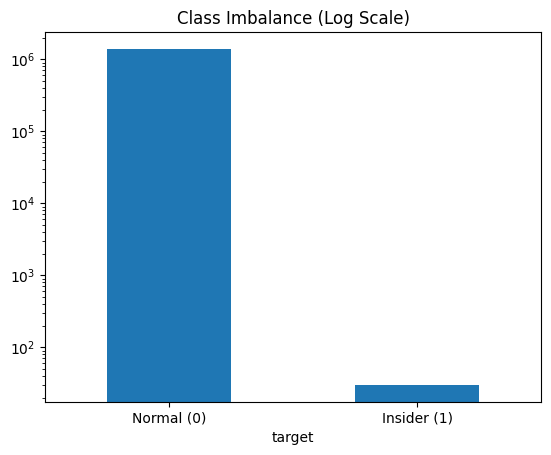

In [30]:
import matplotlib.pyplot as plt

ax = ueba["target"].value_counts().sort_index().plot(kind="bar")
plt.yscale("log")
plt.title("Class Imbalance (Log Scale)")
plt.xticks([0,1], ["Normal (0)", "Insider (1)"], rotation=0)
plt.show()

In [31]:
num_cols = ueba.select_dtypes(include=["int64","float64"]).columns
num_cols = num_cols.drop("target")

In [32]:
ueba.nunique().sort_values(ascending=True)

weekend_flag                     2
target                           2
weekend_http_flag                2
unique_pc_count                  7
after_hours_logon_count         15
logon_count                     18
last_activity_hour              20
first_logon_hour                21
send_count                      23
work_duration_hours             24
usb_read_count                  27
email_count                     35
after_hours_file_count          35
after_hours_email_count         35
unique_file_count               50
usb_copy_count                  53
http_request_count              53
suspicious_url_count            57
unique_domain_count             70
external_email_ratio            86
unique_url_count               119
http_count_zscore              122
after_hours_http_count         166
attachment_per_email           478
date                           516
user                          4000
logon_count_zscore            6264
external_ratio_deviation      7574
email_volume_deviati

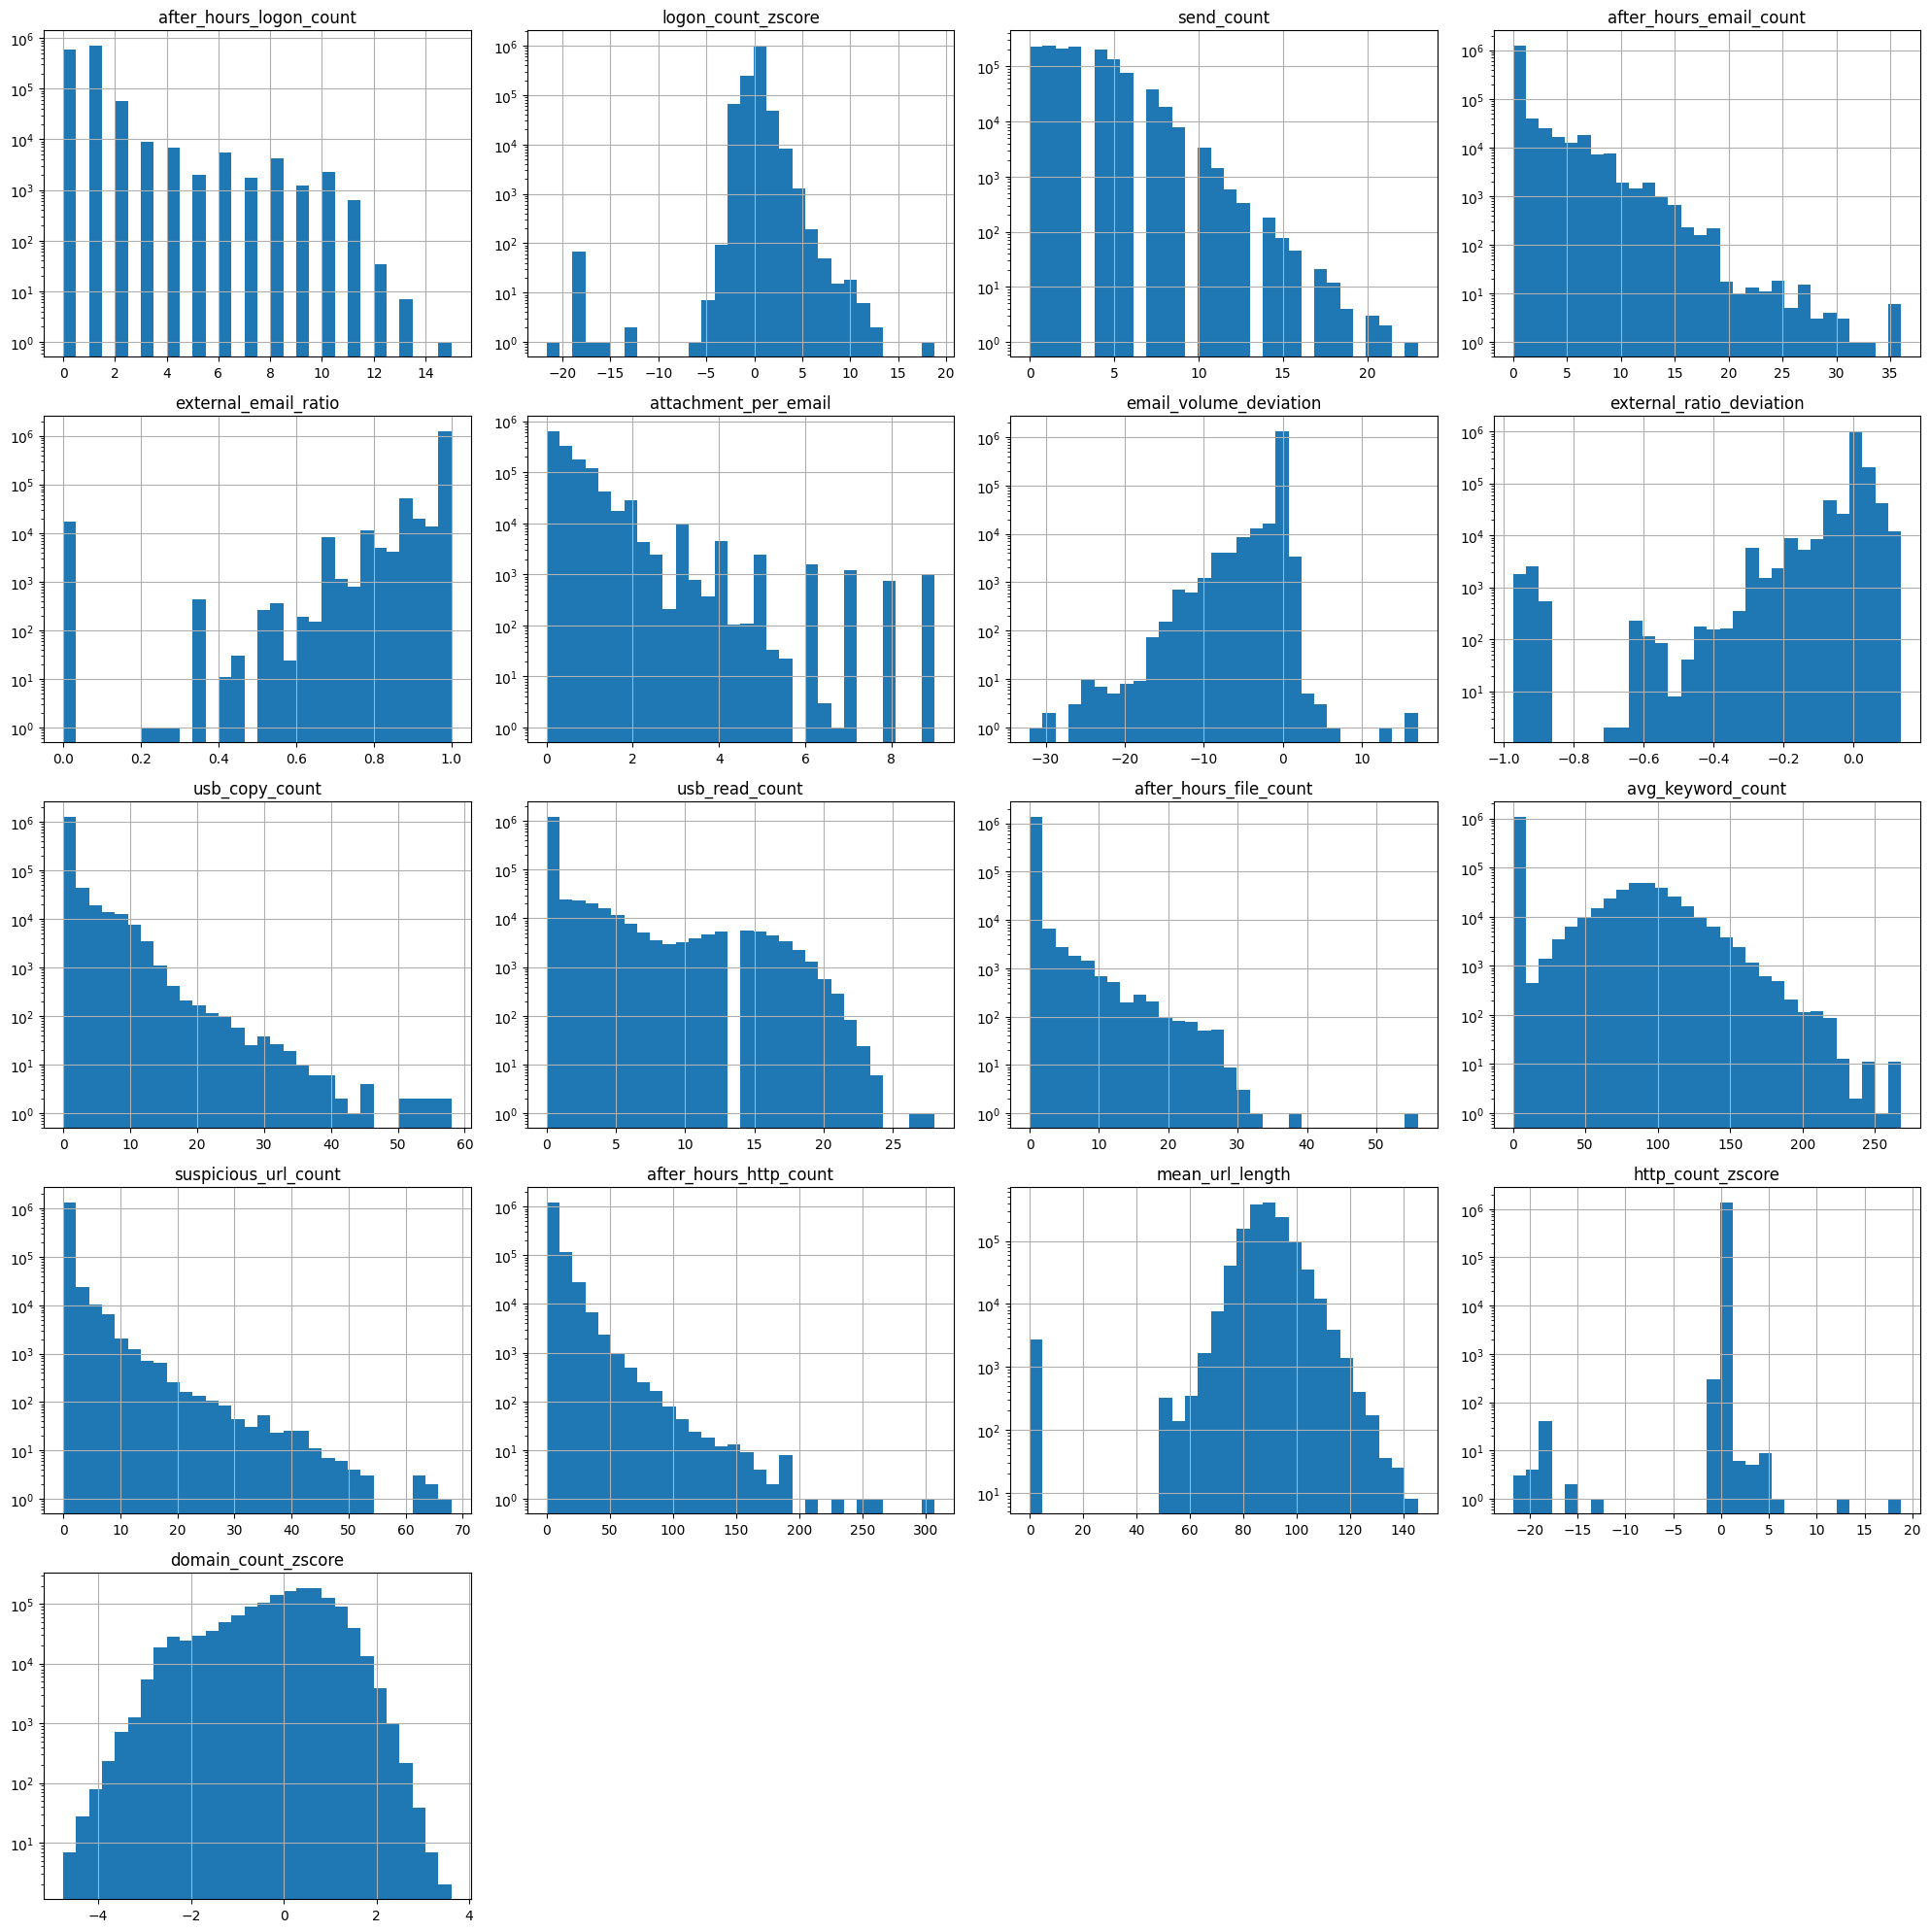

In [33]:
axes = ueba[num_cols].hist(figsize=(20,20), bins=30)

for ax_row in axes:
    for ax in ax_row:
        ax.set_yscale("log")

plt.tight_layout()
plt.show()

In [34]:
df_model = ueba.drop(columns=["user","date"])
num_cols = df_model.select_dtypes(include=["int64","float64"]).columns

In [35]:
corr_matrix = df_model[num_cols].corr()

In [37]:
import numpy as np
import seaborn as sns

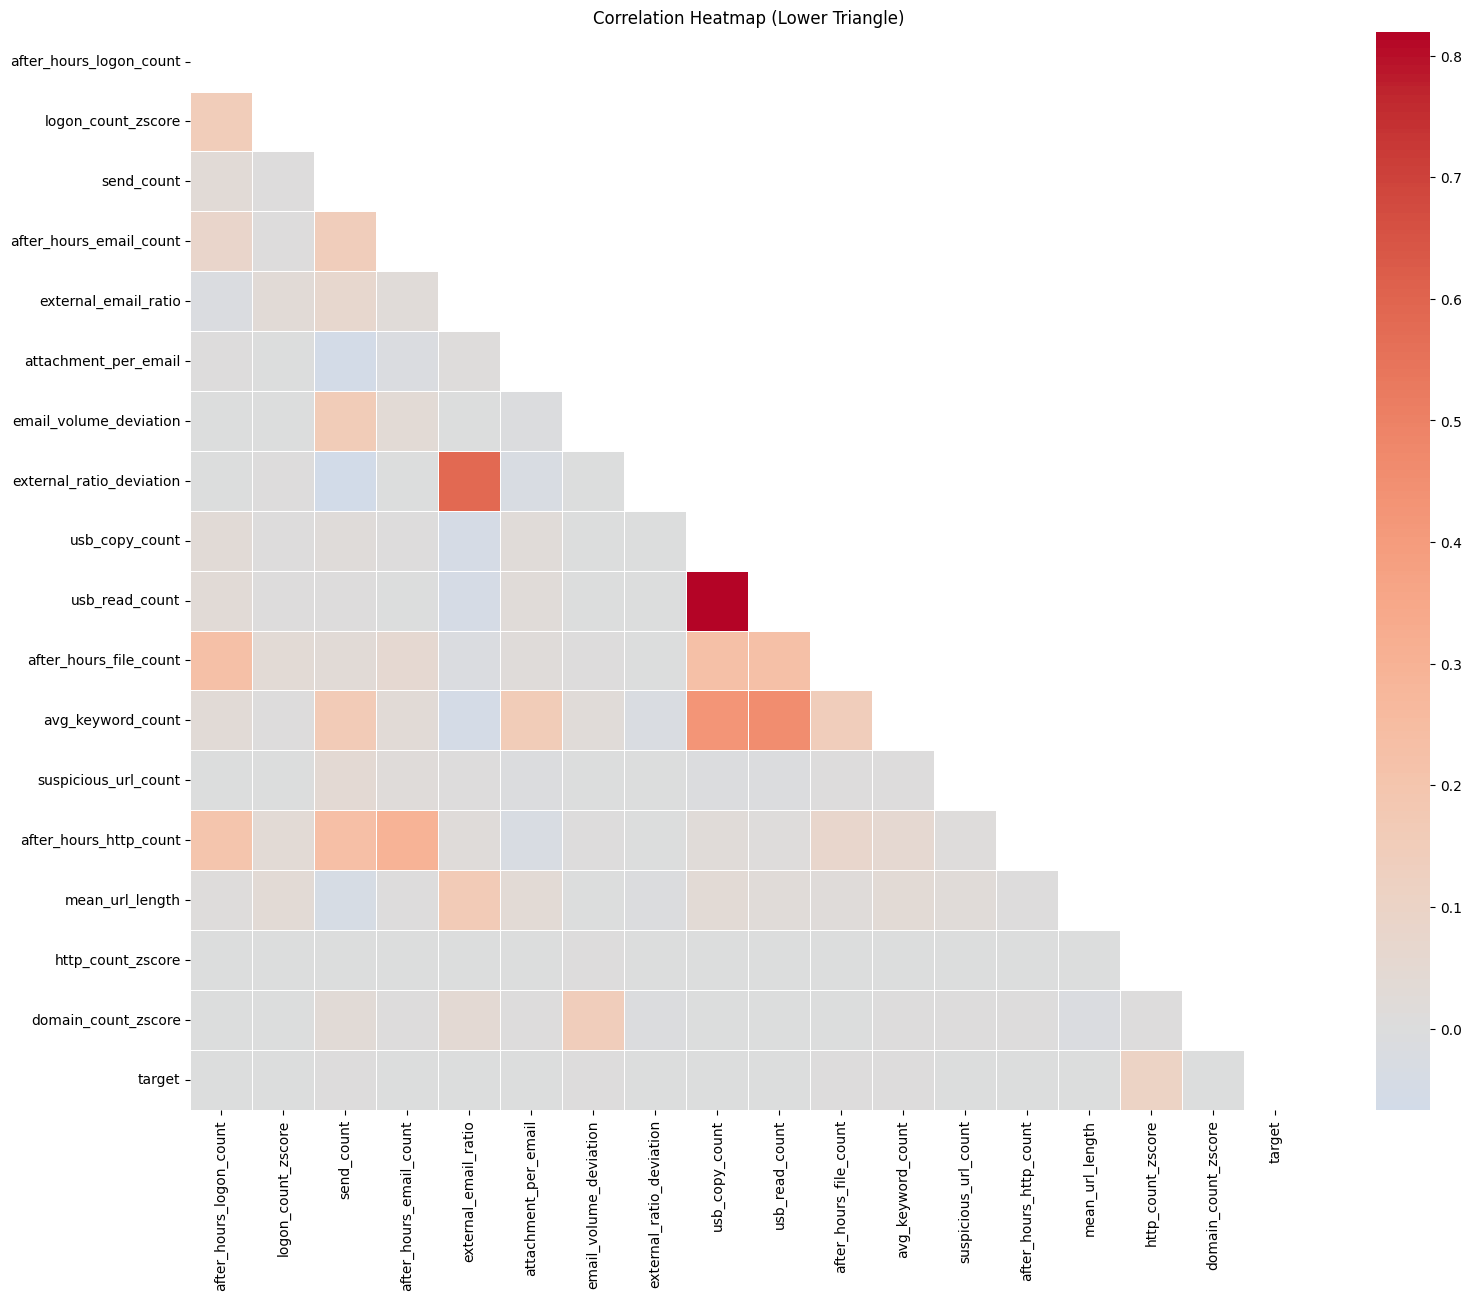

In [38]:
plt.figure(figsize=(18,14))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)

plt.title("Correlation Heatmap (Lower Triangle)")
plt.show()

In [39]:
important_cols = [
    "external_ratio_deviation",
    "email_volume_deviation",
    "logon_count_zscore",
    "http_count_zscore",
    "domain_count_zscore"
]

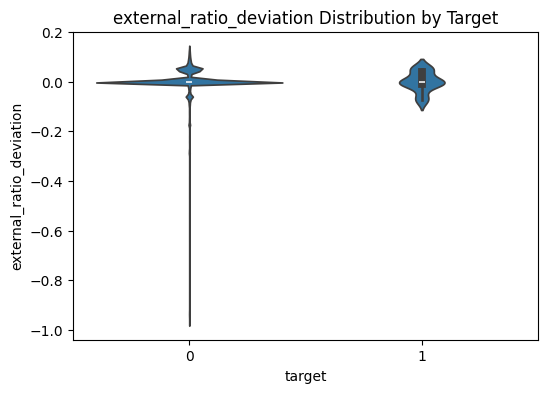

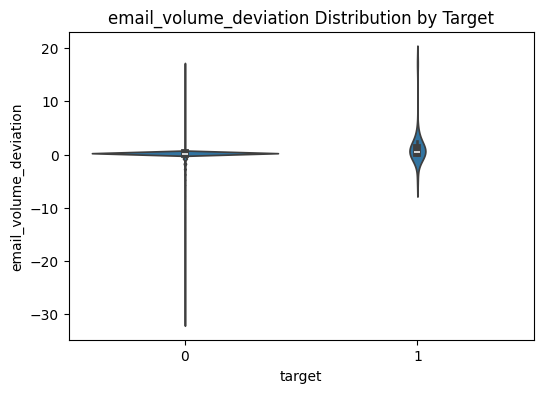

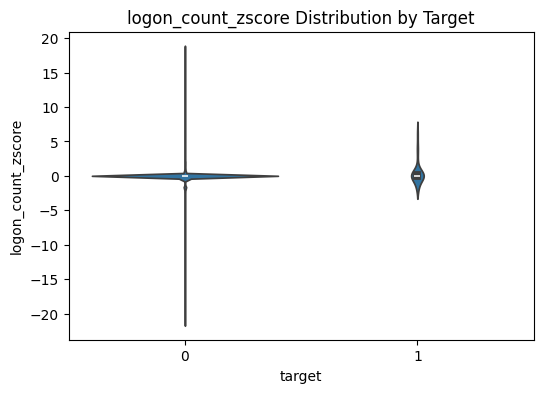

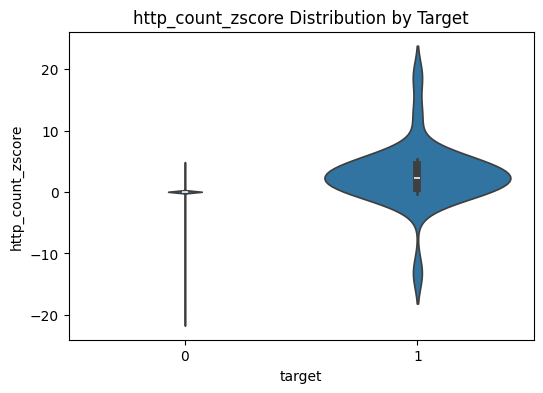

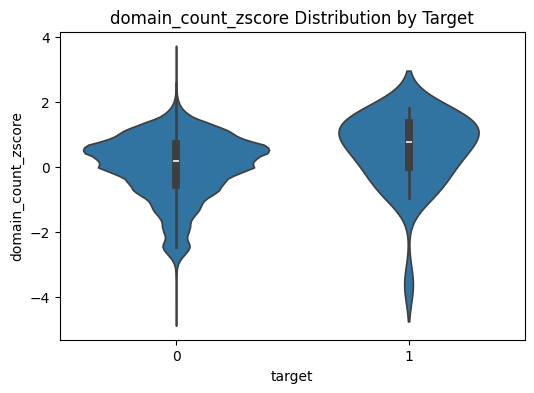

In [40]:
for col in important_cols:
    plt.figure(figsize=(6,4))
    sns.violinplot(x="target", y=col, data=ueba)
    plt.title(f"{col} Distribution by Target")
    plt.show()

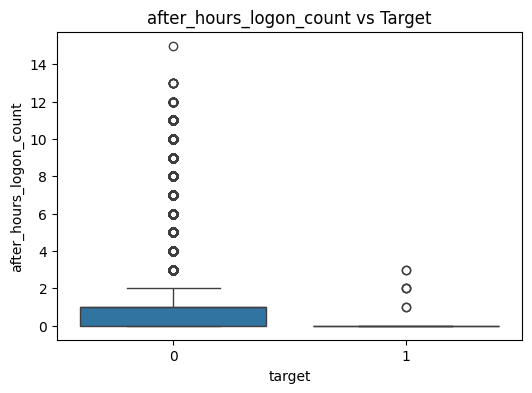

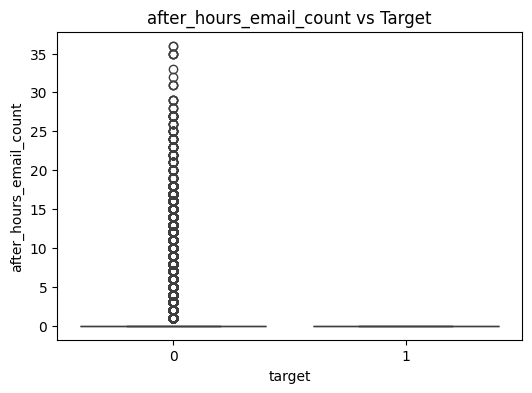

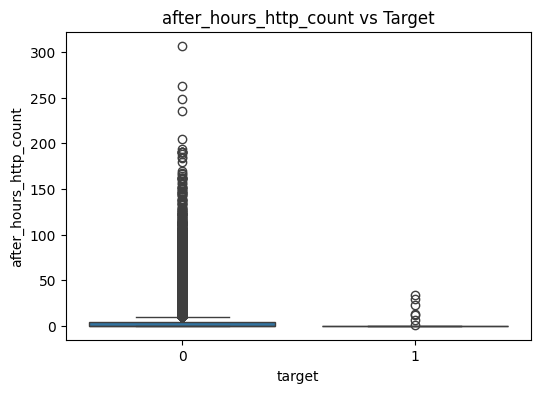

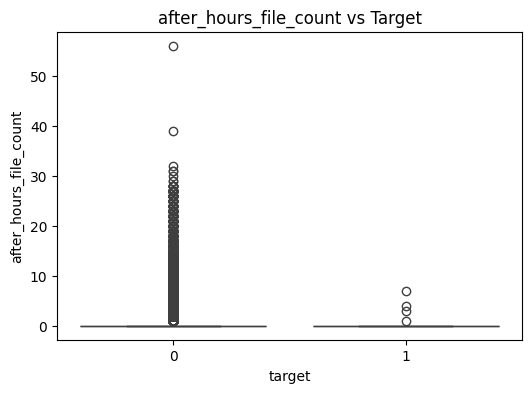

In [41]:
after_hours_cols = [
    "after_hours_logon_count",
    "after_hours_email_count",
    "after_hours_http_count",
    "after_hours_file_count"
]

for col in after_hours_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="target", y=col, data=ueba)
    plt.title(f"{col} vs Target")
    plt.show()

d:\SudhakarF\DocumentsF\SanDiego\Course_10_MLOps\FinalProject\ueba_eda\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


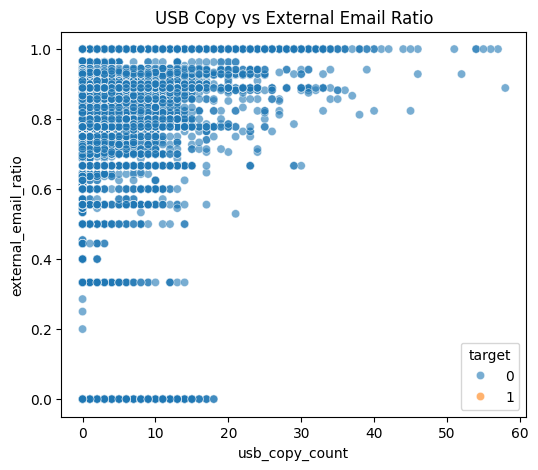

In [42]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x="usb_copy_count",
    y="external_email_ratio",
    hue="target",
    data=ueba,
    alpha=0.6
)
plt.title("USB Copy vs External Email Ratio")
plt.show()

d:\SudhakarF\DocumentsF\SanDiego\Course_10_MLOps\FinalProject\ueba_eda\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


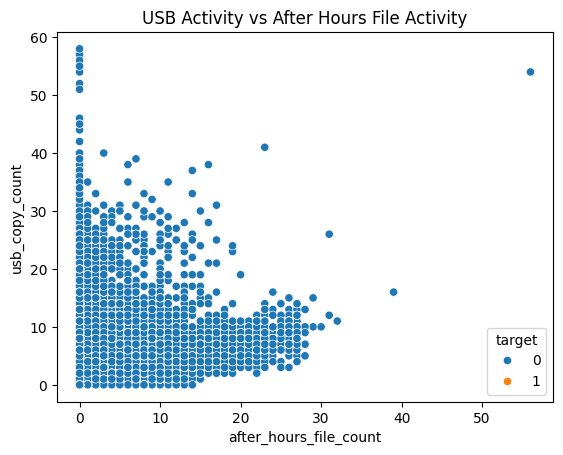

In [48]:
sns.scatterplot(
    x='after_hours_file_count',
    y='usb_copy_count',
    hue='target',
    data=ueba
)
plt.title("USB Activity vs After Hours File Activity")
plt.show()

In [50]:
ueba.info()

<class 'pandas.DataFrame'>
RangeIndex: 1394010 entries, 0 to 1394009
Data columns (total 32 columns):
 #   Column                    Non-Null Count    Dtype        
---  ------                    --------------    -----        
 0   user                      1394010 non-null  object       
 1   date                      1394010 non-null  datetime64[s]
 2   logon_count               1394010 non-null  UInt32       
 3   unique_pc_count           1394010 non-null  UInt32       
 4   first_logon_hour          1394010 non-null  Int8         
 5   last_activity_hour        1394010 non-null  Int8         
 6   after_hours_logon_count   1394010 non-null  Int64        
 7   weekend_flag              1394010 non-null  Int8         
 8   logon_count_zscore        1394010 non-null  Float64      
 9   work_duration_hours       1394010 non-null  Int8         
 10  email_count               1394010 non-null  UInt32       
 11  send_count                1394010 non-null  Int64        
 12  after_hours